## 1. Setup models

In [ ]:
# !git clone https://github.com/HemaxiN/DL_ECG_Classification.git

Cloning into 'DL_ECG_Classification'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 811 (delta 162), reused 204 (delta 127), pack-reused 552 (from 1)
Receiving objects: 100% (811/811), 14.00 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [2]:
!pip install -U -r DL_ECG_Classification/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argon2_cffi-21.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl.metadata (11 kB)
  Using cached debugpy-1.6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached executing-0.8.3-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached fonttools-4.31.2-py3-none-any.whl.metadata (121 kB)
  Using cached importlib_resources-5.6.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached ipykernel-6.

In [ ]:
!pip install -q tifffile pyts wfdb torchmetrics torchsummary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## 2. Setup PTB-XL dataset (v1.0.3)

In [1]:
!wget https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

--2025-05-13 11:52:08--  https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1839504686 (1.7G) [application/zip]
Saving to: ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip’

 ptb-xl-a-large-pub  92%[=================>  ]   1.59G   334KB/s    eta 6m 35s 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
!unzip ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip -d p

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import ast
import pickle
import os


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'ptb-xl-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

def aggregate_diagnostic(y_dic, threshold=50):
    tmp = []
    for key, val in y_dic.items():
        if key in agg_df.index and val>=threshold:
            if key in ['CLBBB', 'ILBBB']:
                label = 'LBBB'
            elif key in ['CRBBB', 'IRBBB']:
                label = 'RBBB'
            elif key == '1AVB':
                label = '1dAVB'
            else:
                label = key
            if label in ['AFIB', 'AFLT', '1dAVB', 'RBBB', 'LBBB', 'NORM']:
                tmp.append(label)
    return list(set(tmp))

# Apply diagnostic superclass
Y['subclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y = Y[Y.subclass.apply(lambda x: len(x) > 0)]

# Split data into train and test (https://physionet.org/content/ptb-xl/1.0.1/)
test_fold = 10
dev_fold = 9

X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != dev_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != dev_fold)].subclass
print(f'Train records: {len(y_train)}')

X_dev = X[np.where(Y.strat_fold == dev_fold)]
y_dev = Y[(Y.strat_fold == dev_fold)].subclass
print(f'Val records: {len(y_dev)}')

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].subclass
print(f'Test records: {len(y_test)}')

Train records: 9672
Val records: 1210
Test records: 1226


In [2]:
# Flatten lists
y_train_flat = pd.Series([', '.join(sublist) for sublist in y_train])
y_dev_flat = pd.Series([', '.join(sublist) for sublist in y_dev])
y_test_flat = pd.Series([', '.join(sublist) for sublist in y_test])

# Get value counts
train_counts = y_train_flat.value_counts()
dev_counts = y_dev_flat.value_counts()
test_counts = y_test_flat.value_counts()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'y_train': train_counts,
    'y_dev': dev_counts,
    'y_test': test_counts
})

summary_df = summary_df.fillna(0)
summary_df

,y_train,y_dev,y_test
1dAVB,428,57.0,55.0
"1dAVB, NORM",30,4.0,2.0
AFIB,37,3.0,8.0
AFLT,47,5.0,4.0
LBBB,405,50.0,54.0
"LBBB, 1dAVB",83,11.0,8.0
NORM,7320,914.0,929.0
RBBB,1039,134.0,129.0
"RBBB, 1dAVB",90,8.0,14.0
"RBBB, LBBB",1,0.0,0.0


In [3]:
preprocessed_dir = 'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X.pickle"),"wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y.pickle"),"wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_train.pickle"),"wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train.pickle"),"wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev.pickle"),"wb")
pickle.dump(X_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev.pickle"),"wb")
pickle.dump(y_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [4]:
def labelstovector(X, y):
    '''
    Convert the labels in y into vectors:
    Multi-label problem:
    NORM: [0,0,0,0,0]
    AFIB: [1,0,0,0,0]
    AFLT: [0,1,0,0,0]
    1dAVb: [0,0,1,0,0]
    RBBB: [0,0,0,1,0]
    LBBB: [0,0,0,0,1]
    Combination example:
    AFLT and LBBB: [0,1,0,0,1]
    LBBB and RBBB and 1dAVB: [0,0,1,1,1]
    -----------------------------------------------------------
    Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
    '''
    y_list = []
    X_list = []
    for label, ecg in zip(y, X):
        if len(label)!= 0: #ignore examples with label = []
            aux_vec = np.zeros(5)
        if 'AFIB' in label:
            aux_vec[0] = 1
        if 'AFLT' in label:
            aux_vec[1] = 1
        if '1dAVB' in label:
            aux_vec[2] = 1
        if 'RBBB' in label:
            aux_vec[3] = 1
        if 'LBBB' in label:
            aux_vec[4] = 1
    
        y_list.append(aux_vec)
        X_list.append(ecg)
    
    return X_list, y_list

In [5]:
X_train_processed, y_train_processed = labelstovector(X_train, y_train)
X_dev_processed, y_dev_processed = labelstovector(X_dev, y_dev)
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_train_processed.pickle"),"wb")
pickle.dump(X_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train_processed.pickle"),"wb")
pickle.dump(y_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev_processed.pickle"),"wb")
pickle.dump(X_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev_processed.pickle"),"wb")
pickle.dump(y_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Train size:', X_train.shape)
print('Val size:', X_dev.shape)
print('Test size:', X_test.shape)

Train size: (9672, 1000, 12)
Val size: (1210, 1000, 12)
Test size: (1226, 1000, 12)


In [6]:
# Prepare 2D dataset
!mkdir -p Images/dev/labels
!mkdir -p Images/dev/images
!mkdir -p Images/train/labels
!mkdir -p Images/train/images
!mkdir -p Images/test/labels
!mkdir -p Images/test/images

# Save processed dataset at
!mkdir -p Processed/model_specific/X_rnn_train
!mkdir -p Processed/model_specific/X_rnn_dev
!mkdir -p Processed/model_specific/X_rnn_test
!mkdir -p Processed/model_specific/X_cnn_train
!mkdir -p Processed/model_specific/X_cnn_dev
!mkdir -p Processed/model_specific/X_cnn_test
!mkdir -p Processed/model_specific/labels_train
!mkdir -p Processed/model_specific/labels_dev
!mkdir -p Processed/model_specific/labels_test

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python DL_ECG_Classification/Dataset/create_dataset.py

0
1
2
3
4
5
6
7
8
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/Dataset/create_images.py:141: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)
9
10
11
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/Dataset/create_images.py:141: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/Dataset/create_images.py:141: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)
12
13
14
15
16
17
18
19
20
21
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/Dataset/create_images.py:141: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)
22
23
24
25
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/Dataset/create_images.py:141: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)
26
27
28
29
30
31
32
3

Model output (5,)
[0. 0. 0. 0. 0.]

1D input: (1000, 3)
[[-1.54393184 -0.76366823 -1.79032348]
 [-1.76437621 -0.92009947 -1.77285192]
 [-0.42336687 -0.36026072  0.07644246]
 ...
 [ 0.75933154  0.94011272  0.76558717]
 [ 0.8445424   1.19758285  0.69151829]
 [ 1.77366119  1.38579736  0.59901788]]

2D input: (256, 256)


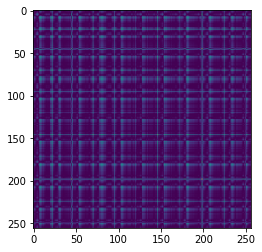

In [7]:
# View label
label = np.load('Processed/model_specific/labels_dev/0.npy')
print('Model output', label.shape)
print(label)

# View RNN input
rnn_input = np.load('Processed/model_specific/X_rnn_dev/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('Processed/model_specific/X_cnn_dev/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

## 3. Training

In [8]:
%cd DL_ECG_Classification

/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification


### 3.1 1D models

In [10]:
## RNN
!python3 rnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
Training loss: 1.7205
Valid specificity: 0.5354
Valid sensitivity: 0.4999
Training epoch 2
Training loss: 1.5577
Valid specificity: 0.5044
Valid sensitivity: 0.4760
Training epoch 3
Training loss: 1.4900
Valid specificity: 0.4135
Valid sensitivity: 0.6120
Training epoch 4
Training loss: 1.4675
Valid specificity: 0.5584
Valid sensitivity: 0.3987
Training epoch 5
Training loss: 1.4431
Valid specificity: 0.6566
Valid sensitivity: 0.3523
Training epoch 6
Training loss: 1.4347
Valid specificity: 0.5529
Valid sensitivity: 0.4096
Training epoch 7
Training loss: 1.4229
Valid specificity: 0.4786
Valid sensitivity: 0.4439
Training epoch 8
Training loss: 1.4181
Valid specificity: 0.5515
Valid sensitivity: 0.4011
Training epoch 9
Training loss: 1.4088
Valid specificity: 0.6920
Valid sensitivity: 0.2786
Training epoch 10
Training loss: 1.4005
Valid specificity: 0.4436
Valid sensitivity: 0.4757
Training epoch 11
Training loss: 1.3974
Valid specificity: 0.6234
Valid s

In [15]:
## LSTM
!python3 lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
Training loss: 1.5097
Training epoch 20
Training loss: 1.4893
Training epoch 30
Training loss: 1.4815
Training epoch 40
Training loss: 1.4765
^Cal 385 of 1210
Traceback (most recent call last):
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/lstm.py", line 313, in <module>
    main()
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/lstm.py", line 272, in main
    val_loss = compute_loss(model, dev_dataloader, criterion, gpu_id=opt.gpu_id)
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/lstm.py", line 141, in compute_loss
    y_pred = model(x_batch)
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/nepython/projects

In [16]:
## GRU
!python3 gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.005
!python3 gru_with_attention.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.05

Loading data...
Training epoch 1
Training loss: 1.4747
Training epoch 2
Training loss: 1.4664
Training epoch 3
Training loss: 1.4621
Training epoch 4
Training loss: 1.4589
^C
Traceback (most recent call last):
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/gru.py", line 375, in <module>
    main()
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/gru.py", line 338, in main
    val_loss = compute_loss(model, dev_dataloader, criterion, gpu_id=opt.gpu_id)
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/gru.py", line 200, in compute_loss
    y_pred = model(x_batch)
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/nepython/projects/COMP6011/Task3/DL_E

### 3.2 2D models

In [12]:
## AlexNet
!python3 AlexNet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training loss: 1.4764
Training epoch 2
Training loss: 1.4604
Training epoch 3
Training loss: 1.4459
Training epoch 4
Training loss: 1.4323
Training epoch 5
Training loss: 1.4191
Tr

In [14]:
## VGGNet
!python3 vggnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
^Cof 38
Traceback (most recent call last):
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/vggnet.py", line 230, in <module>
    main()
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/vggnet.py", line 186, in main
    for i, (X_batch, y_batch) in enumerate(train_dataloader):
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=defaul

In [13]:
## ResNet
!python3 resnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training loss: 1.5181
Valid specificity: 0.1035
Valid sensitivity: 0.9956
Training epoch 2
Training loss: 1.5180
Valid specificity: 0.2471
Valid sensitivity: 0.7997
Training epoch 

In [88]:
## CNN
!python3 cnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python cnn_gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python cnn_lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training loss: 0.6598
Training epoch 2
Training loss: 0.5934
Training epoch 3
Training loss: 0.4510
Training epoch 4
Training loss: 0.3534
Training epoch 5
Training loss: 0.2933
Tr

### 3.3 Fusion approaches

Fusion uses 1D and 2D models so let's shift it's best models to new folder Models.

In [156]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [163]:
!python early_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Namespace(signal_data='../Processed/model_specific/', image_data='../Processed/model_specific/', signal_model='gru', image_model='alexnet', epochs=100, batch_size=256, learning_rate=0.01, dropout=0, l2_decay=0, optimizer='adam', gpu_id=0, path_save_model='saved_models/', hidden_size=256, early_stop=True, patience=10)
True 0 NVIDIA GeForce RTX 4090
+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| fc_img.weight |  1048576   |
|  fc_img.bias  |    256     |
|   fc1.weight  |   262144   |
|    fc1.bias   |    512     |
|   fc2.weight  |   131072   |
|    fc2.bias   |    256     |
|   out.weight  |    1280    |
|    out.bias   |     5      |
+---------------+------------+
Total Trainable Params: 1444101
Starting early fusion training at: 2025-05-30_02-38-27
Save models at: saved_models/EarlyFusionNet
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: C

In [168]:
!python late_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Namespace(signal_data='../Processed/model_specific/', image_data='../Processed/model_specific/', signal_model='gru', image_model='alexnet', epochs=100, batch_size=256, learning_rate=0.01, dropout=0.0, l2_decay=0, optimizer='adam', gpu_id=0, path_save_model='saved_models/', hidden_size=512, early_stop=True, patience=20)
True 0 NVIDIA GeForce RTX 4090
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| hidden.weight |    5120    |
|  hidden.bias  |    512     |
|   out.weight  |    2560    |
|    out.bias   |     5      |
+---------------+------------+
Total Trainable Params: 8197
Sta

In [172]:
!python joint_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Namespace(signal_data='../Processed/model_specific/', image_data='../Processed/model_specific/', signal_model='gru', image_model='alexnet', epochs=100, batch_size=256, learning_rate=0.01, dropout=0, l2_decay=0.01, optimizer='adam', gpu_id=0, path_save_model='saved_models/', hidden_size=256, early_stop=True, patience=10)
True 0 NVIDIA GeForce RTX 4090
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
| sig_model.rnn.weight_ih_l0 |    2304    |
| sig_model.rnn.weight_hh_l0 |   196608   |
|  sig_model.rnn.bias_ih_l0  |    768     |
|  sig_model.rnn.bias_hh_l0  |    768     |
| sig_model.rnn.weight_ih_l1 |   196608   |
| sig_model.rnn.weight_hh_l1 |   196608   |
|  sig_model.rnn.bias_ih_l1  |    768     |
|  sig_model.rnn.bias_hh_l1  |    768     |
| img_model.conv2d_1.weight  |    8712    |
|  img_model.conv2d_1.bias   |     8      |
| img_model.conv2d_2.weight  |    3200    |
|  img_model.conv2d_2.bias   | 

## Evaluation

First, move best models to a separate directory

In [173]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [178]:
!python eval_saved_models.py -gpu_id 0 \
    -model gru \
    -path Models/GRU \
    -data ../Processed/assignment_val/

/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in tru

array([1., 0., 0., 0.])